# RFSoC RF-DC Frequency Planner

In [1]:
import numpy as np
from ipywidgets import widgets
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # garbage collection should close plots when finished so safe to supress this warning
# %matplotlib widget

## RF-ADC

In [2]:
class FrequencyPlannerADC:

    def __init__(self, fs_rf=4092, fc=1175.42, fs_bw=10.23, pll_ref=409.2, il_factor=8):
        self.fs_rf = fs_rf
        self.fc = fc
        self.fs_bw = fs_bw
        self.pll_ref = pll_ref
        self.il_factor = il_factor
        
        self.f = np.linspace(-0.5,0.5,101)
        
    @property
    def signal_f(self):
        fs_rf = self.fs_rf
        fs_bw = self.fs_bw
        fc = self.fc
        f = self.f
        
        return [fs_rf - ((fc+fs_bw*i) % fs_rf) if ((fc+fs_bw*i) % fs_rf) >= fs_rf/2 else ((fc+fs_bw*i) % fs_rf) for i in f]

    @property
    def interf_f(self):
        fc = self.fc
        fs_bw = self.fs_bw
        f = self.f
        return [fc+(fs_bw*i) for i in f]
    
    @property    
    def hd(self):
        fs_rf = self.fs_rf
        interf_f = self.interf_f
        
        hd2 = [fs_rf - (2*i % fs_rf) if 2*i % fs_rf >= fs_rf/2 else (2*i % fs_rf) for i in interf_f]
        hd3 = [fs_rf - (3*i % fs_rf) if 3*i % fs_rf >= fs_rf/2 else (3*i % fs_rf) for i in interf_f]
        hd4 = [fs_rf - (4*i % fs_rf) if 4*i % fs_rf >= fs_rf/2 else (4*i % fs_rf) for i in interf_f]
        hd5 = [fs_rf - (5*i % fs_rf) if 5*i % fs_rf >= fs_rf/2 else (5*i % fs_rf) for i in interf_f]
        
        return hd2, hd3, hd4, hd5
    
    @property
    def il(self):
        fs_rf = self.fs_rf
        signal_f = self.signal_f
        interf_f = self.interf_f
        il_factor = self.il_factor
        
        if il_factor > 1:
            il1 = [abs(fs_rf/2 - i) for i in signal_f]
        else:
            il1 = 0

        if il_factor > 2:
            il2 = [abs(fs_rf/4 - i) for i in signal_f]
            il3 = [abs(fs_rf/4 + i) if ((fs_rf/4 + i) < fs_rf/2) else abs(fs_rf/4*3-i) for i in signal_f]
        else:
            il2 = il3 = 0

        if il_factor > 4:
            il4 = [abs(fs_rf/8 - i) for i in signal_f]
            il5 = [abs(fs_rf/8 + i) if ((fs_rf/8 + i) < fs_rf/2) else abs(fs_rf/8*7-i) for i in signal_f]
            il6 = [abs(fs_rf/8*3-i) for i in signal_f]
            il7 = [abs(fs_rf/8*3+i) if ((fs_rf/8*3+i) < fs_rf/2) else abs(fs_rf/8*5-i) for i in signal_f]
        else:
            il4 = il5 = il6 = il7 = 0

        return il1, il2, il3, il4, il5, il6, il7
    
    @property
    def fs_hd(self):
        fs_rf = self.fs_rf
        il_factor = self.il_factor
        hd2 = self.hd[0]
        hd3 = self.hd[1]

        if il_factor > 1:
            fs2_m_hd2 = [abs(fs_rf/2-i) for i in hd2]
            fs2_m_hd3 = [fs_rf/2-i for i in hd3]
        else:
            fs2_m_hd2 = fs2_m_hd3 = 0

        if il_factor > 2:
            fs4_m_hd2 = [abs(fs_rf/4-i) for i in hd2]
            fs4_p_hd2 = [abs(fs_rf/4+i) if (fs_rf/4+i < fs_rf/2) else abs(fs_rf/4*3-i) for i in hd2]
            fs4_m_hd3 = [abs(fs_rf/4-i) for i in hd3]
            fs4_p_hd3 = [abs(fs_rf/4+i) if (fs_rf/4+i < fs_rf/2) else abs(fs_rf/4*3-i) for i in hd3]    
        else:
            fs4_m_hd2 = fs4_p_hd2 = fs4_m_hd3 = fs4_p_hd3 = 0

        if il_factor > 4:
            fs8_m_hd2 = [abs(fs_rf/8-i) for i in hd2]
            fs8_p_hd2 = [abs(fs_rf/8+i) if (fs_rf/8+i < fs_rf/2) else abs(fs_rf/8*7-i) for i in hd2]
            fs8_m_hd3 = [abs(fs_rf/8-i) for i in hd3]
            fs8_p_hd3 = [abs(fs_rf/8+i) if (fs_rf/8+i < fs_rf/2) else abs(fs_rf/8*7-i) for i in hd3]
        else:
            fs8_m_hd2 = fs8_p_hd2 = fs8_m_hd3 = fs8_p_hd3 = 0

        return fs2_m_hd2, fs2_m_hd3, fs4_m_hd2, fs4_p_hd2, fs4_m_hd3, fs4_p_hd3, fs8_m_hd2, fs8_p_hd2, fs8_m_hd3, fs8_p_hd3

    @property
    def clk_mix_prod(self):
        fs_rf = self.fs_rf
        fc = self.fc
        fs_bw = self.fs_bw
        pll_ref = self.pll_ref
        f = self.f
        
        clk_mix_prod_up = [fs_rf - ((fc+fs_bw*i+pll_ref) % fs_rf) if ((fc+fs_bw*i+pll_ref) % fs_rf) >= fs_rf/2 else ((fc+fs_bw*i+pll_ref) % fs_rf) for i in f]
        clk_mix_prod_down = [fs_rf - ((fc+fs_bw*i-pll_ref) % fs_rf) if ((fc+fs_bw*i-pll_ref) % fs_rf) >= fs_rf/2 else ((fc+fs_bw*i-pll_ref) % fs_rf) for i in f]
        
        return clk_mix_prod_up, clk_mix_prod_down
    
    @property
    def calibration_mode(self):
        fs_rf = self.fs_rf
        fc = self.fc
        
        if ((fs_rf/2*0.7 < fc) and (fc < fs_rf/2*1.3)) or ((fs_rf/2*3-0.3*fs_rf/2 < fc) and (fc < fs_rf/2*3+0.3*fs_rf/2)) or ((fs_rf/2*5-0.3*fs_rf/2 < fc) and (fc < fs_rf/2*5+0.3*fs_rf/2)) or ((fs_rf/2*7-0.3*fs_rf/2 < fc) and (fc < fs_rf/2*7+0.3*rf_fs/2)) or ((fs_rf/2*9+0.3*fs_rf/2 < fc) and (fc < fs_rf/2*9+0.3*fs_rf/2)):
            return "Calibration Mode: Mode 1"
        else:
            return "Calibration Mode: Mode 2"
        
    @property
    def pparams(self):
        p_rx = {'label':'Rx Band', 'marker':'D', 'color':'tab:blue', 'y':6}
        p_nyq = {'label':'Nyquist', 'marker':'D', 'color':'tab:gray', 'y':6}
        p_hd2 = {'label':'HD2', 'marker':'D', 'color':'tab:orange', 'y':2}
        p_hd3 = {'label':'HD3', 'marker':'D', 'color':'tab:orange', 'y':3}
        p_hd4 = {'label':'HD4', 'marker':'D', 'color':'tab:orange', 'y':4}
        p_hd5 = {'label':'HD5', 'marker':'D', 'color':'tab:orange', 'y':5}
        
        return p_rx, p_nyq, p_hd2, p_hd3, p_hd4, p_hd5

In [3]:
class FrequencyPlannerPlot:
    
    def __init__(self, fig, ax, x):
        self.fig = fig
        self.ax = ax
#         self.loc = loc
        
        self.ax.set_xlabel('Frequency (MHz)', fontsize=10)
        self.ax.set_ylabel('Harmonic No.', fontsize=10)
        self.ax.set_xlim([0, 4096 + 4096*0.01])
        self.ax.set_ylim([0, 7])
        self.ax.grid(True)
        
        self.rx_line_a, = self.ax.plot([0,0], np.repeat(x.pparams[0]['y'],2), label=x.pparams[0]['label'], marker=x.pparams[0]['marker'], color=x.pparams[0]['color'])
        self.rx_line_b = self.ax.axvline(x=0, ymin=0, ymax=6/7, color=x.pparams[0]['color'])
        self.rx_line_c = self.ax.axvline(x=0, ymin=0, ymax=6/7, color=x.pparams[0]['color'])
    
        # Nyquist
        self.nyq_line_a, = ax.plot(0, x.pparams[1]['y'], marker=x.pparams[1]['marker'], color=x.pparams[1]['color'], label=x.pparams[1]['label'])
        self.nyq_line_b  = ax.axvline(x=0, ymin=0, ymax=6/7, color=x.pparams[1]['color'])
        
        ax.legend(bbox_to_anchor=(1.05,1),fontsize=9, borderaxespad=0., loc=2)

        self.fig.tight_layout()
    
    def update_plot(self, x):
        
#         self.ax.set_xlim([0, x.fs_rf/2 + x.fs_rf*0.01])
        
        # Rx Band
        self.rx_line_a.set_xdata([min(x.signal_f), max(x.signal_f)])
        self.rx_line_b.set_xdata(min(x.signal_f))
        self.rx_line_c.set_xdata(max(x.signal_f))
        
        # Nyquist Band
        self.nyq_line_a.set_xdata(x.fs_rf/2)
        self.nyq_line_b.set_xdata(x.fs_rf/2)
        
        self.fig.canvas.draw()

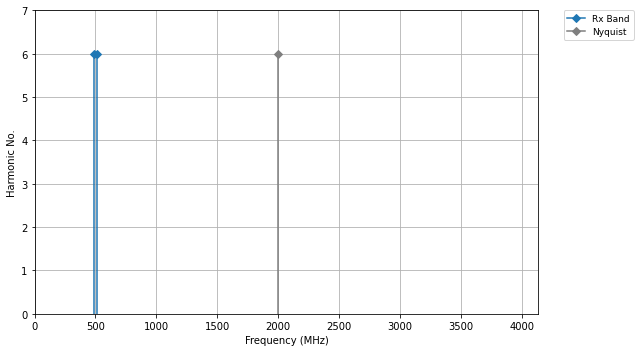

In [270]:
fig_adc = plt.figure(figsize=(9,5))
ax_adc = fig_adc.add_subplot(111)

data_adc = FrequencyPlannerADC(4000, 1200, 20, 409.2, 8)
plot_adc = FrequencyPlannerPlot(fig_adc, ax_adc, data_adc)
data_adc.fc = 500
plot_adc.update_plot(data_adc)

## RF-DAC

In [538]:
class FrequencyPlannerDAC:
    
    def __init__(self, fs_rf=4092, fc=1175.42, fs_bw=10.23, pll_ref=409.2):
        self.fs_rf = fs_rf
        self.fc = fc
        self.fs_bw = fs_bw
        self.pll_ref = pll_ref

        self.f = np.linspace(-0.5,0.5,101)

    @property
    def signal_f(self):
        fs_rf = self.fs_rf
        fs_bw = self.fs_bw
        fc = self.fc
        f = self.f

        return [fc + (fs_bw*i) for i in f]
    
    @property
    def tx_signal(self):
        ax_x = self.signal_f
        ax_y = 8
        
        return {'label':'TX signal', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'cornflowerblue', 'linestyle':'solid'}
    
    @property
    def nyquist(self):
        ax_x = self.fs_rf/2
        ax_y = 8
        
        return {'label':'Nyquist', 'xmin':ax_x, 'xmax':ax_x, 'y':ax_y, 'color':'royalblue', 'linestyle':'solid'}
    
    @property
    def nyquist_image(self):
        ax_x = self.fs_rf
        ax_y = 8
        
        return {'label':'Nyquist', 'xmin':ax_x, 'xmax':ax_x, 'y':ax_y, 'color':'forestgreen', 'linestyle':'solid'}
    
    def __hd_nyq1(self, hd_num):
        nyq_rf = self.fs_rf/2
        signal_f = self.signal_f
        
        ax_x = [(i*hd_num % nyq_rf) if ((int((i*2)/nyq_rf) % 2)  == 0) else (nyq_rf - (i*hd_num % nyq_rf)) for i in signal_f]
        
        return ax_x
    
    def __hd_nyq2(self, hd_num):
        hd = self.__hd_nyq1(hd_num)
        nyq_rf = self.fs_rf/2
        
        ax_x = [2*nyq_rf - i for i in hd]
        
        return ax_x
    
    @property
    def hd2_nyq1(self):
        hd_num = 2
        ax_x = self.__hd_nyq1(hd_num)
        ax_y = hd_num
        
        return {'label':'HD2_1NYQ', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'darkorange', 'linestyle':'solid'}
    
    @property
    def hd3_nyq1(self):
        hd_num = 3
        ax_x = self.__hd_nyq1(hd_num)
        ax_y = hd_num
        
        return {'label':'HD3_1NYQ', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'lightgrey', 'linestyle':'solid'}
    
    @property
    def hd4_nyq1(self):
        hd_num = 4
        ax_x = self.__hd_nyq1(hd_num)
        ax_y = hd_num
        
        return {'label':'HD4_1NYQ', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'khaki', 'linestyle':'solid'}
    
    @property
    def hd5_nyq1(self):
        hd_num = 5
        ax_x = self.__hd_nyq1(hd_num)
        ax_y = hd_num
        
        return {'label':'HD5_1NYQ', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'tab:blue', 'linestyle':'solid'}
    
    @property
    def hd2_nyq2(self):
        hd_num = 2
        ax_x = self.__hd_nyq2(hd_num)
        ax_y = hd_num
        
        return {'label':'HD2_2NYQ', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'tab:green', 'linestyle':'solid'}
    
    @property
    def hd3_nyq2(self):
        hd_num = 3
        ax_x = self.__hd_nyq2(hd_num)
        ax_y = hd_num
        
        return {'label':'HD3_2NYQ', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'royalblue', 'linestyle':'solid'}
    
    @property
    def hd4_nyq2(self):
        hd_num = 4
        ax_x = self.__hd_nyq2(hd_num)
        ax_y = hd_num
        
        return {'label':'HD4_2NYQ', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'saddlebrown', 'linestyle':'solid'}
    
    @property
    def hd5_nyq2(self):
        hd_num = 5
        ax_x = self.__hd_nyq2(hd_num)
        ax_y = hd_num
        
        return {'label':'HD5_2NYQ', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'rebeccapurple', 'linestyle':'solid'}
    
    def __fimg(self):
        signal_f = self.signal_f
        nyq_rf = self.fs_rf/2
        
        ax_x = [(2*nyq_rf - i) if (int(i/nyq_rf) % 2 == 0) else (nyq_rf - (i % nyq_rf)) for i in signal_f]
        
        return ax_x
    
    @property
    def fimg(self):        
        ax_x = self.__fimg()
        ax_y = 8
        
        return {'label':'Fimag', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'sienna', 'linestyle':'solid'}
    
    @property
    def pll_mix_up(self):
        signal_f = self.signal_f
        
        ax_x = [(i + self.pll_ref) for i in signal_f]
        ax_y = 6.5
        
        return {'label':'PLL Mixing', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'khaki', 'linestyle':'solid'}
    
    @property
    def pll_mix_up_image(self):
        fimag = self.__fimg()
        
        ax_x = [(i + self.pll_ref) for i in fimag]
        ax_y = 6.5
        
        return {'label':'PLL Mixing', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'lightgrey', 'linestyle':'solid'}
    
    @property
    def pll_mix_down(self):
        signal_f = self.signal_f
        
        ax_x = [abs(i - self.pll_ref) for i in signal_f]
        ax_y = 6.5
        
        return {'label':'PLL Mixing', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'tab:orange', 'linestyle':'solid'}
    
    @property
    def pll_mix_down_image(self):
        fimg = self.__fimg()
        
        ax_x = [abs(i - self.pll_ref) for i in fimg]
        ax_y = 6.5
        
        return {'label':'PLL Mixing', 'xmin':min(ax_x), 'xmax':max(ax_x), 'y':ax_y, 'color':'tab:blue', 'linestyle':'solid'}
    
    @property
    def get_dicts(self): #####!!!!!!!!!!!
        
        dict_list = [self.tx_signal, self.hd2_nyq1, self.hd3_nyq1, self.hd4_nyq1, self.hd5_nyq1,
                    self.hd2_nyq2, self.hd3_nyq2, self.hd4_nyq2, self.hd5_nyq2, 
                    self.pll_mix_up, self.pll_mix_up_image, self.pll_mix_down,
                    self.pll_mix_down_image, self.nyquist, self.nyquist_image
                    ]
        
        x_max = max([i['xmax'] for i in dict_list])
        x_max = x_max + x_max*0.2
        x_min = min([i['xmin'] for i in dict_list])
        x_min = x_min + x_min*0.2
        
        y_max = 9
        y_min = 0
        
        init_dict = {'label':'init', 'xmin':x_min, 'xmax':x_max, 'ymin':y_min, 'ymax':y_max}
        
        return [init_dict] + dict_list

In [539]:
data_dac = FrequencyPlannerDAC(fs_rf=4000, fc=1000, fs_bw=100, pll_ref=500)

In [540]:
data_dac.get_dicts

[{'label': 'init', 'xmin': 540.0, 'xmax': 4800.0, 'ymin': 0, 'ymax': 9},
 {'label': 'TX signal',
  'xmin': 950.0,
  'xmax': 1050.0,
  'y': 8,
  'color': 'cornflowerblue',
  'linestyle': 'solid'},
 {'label': 'HD2_1NYQ',
  'xmin': 1900.0,
  'xmax': 2000.0,
  'y': 2,
  'color': 'darkorange',
  'linestyle': 'solid'},
 {'label': 'HD3_1NYQ',
  'xmin': 850.0,
  'xmax': 1000.0,
  'y': 3,
  'color': 'lightgrey',
  'linestyle': 'solid'},
 {'label': 'HD4_1NYQ',
  'xmin': 1800.0,
  'xmax': 2000.0,
  'y': 4,
  'color': 'khaki',
  'linestyle': 'solid'},
 {'label': 'HD5_1NYQ',
  'xmin': 750.0,
  'xmax': 1000.0,
  'y': 5,
  'color': 'tab:blue',
  'linestyle': 'solid'},
 {'label': 'HD2_2NYQ',
  'xmin': 2000.0,
  'xmax': 2100.0,
  'y': 2,
  'color': 'tab:green',
  'linestyle': 'solid'},
 {'label': 'HD3_2NYQ',
  'xmin': 3000.0,
  'xmax': 3150.0,
  'y': 3,
  'color': 'royalblue',
  'linestyle': 'solid'},
 {'label': 'HD4_2NYQ',
  'xmin': 2000.0,
  'xmax': 2200.0,
  'y': 4,
  'color': 'saddlebrown',
  'line

## DDC

In [477]:
class FrequencyPlannerDDC:
    def __init__(self, fs_rf=4096, il_factor=8, fc=1024, dec=8, nco=100, hd2_db=70, hd3_db=70, tis_spur_db=70, off_spur_db=70, pll_mix_db=70, pll_ref=500, nsd_db=-154):
        self.fs_rf = fs_rf
        self.il_factor = il_factor
        self.fc = fc
        self.dec = dec
        self.nco = nco
        self.hd2_db = hd2_db
        self.hd3_db = hd3_db
        self.tis_spur_db = tis_spur_db
        self.off_spur_db = off_spur_db
        self.pll_mix_db = pll_mix_db
        self.pll_ref = pll_ref
        self.nsd_db = nsd_db
        
    def __noisefloor(self):
        return (self.nsd_db + 10*np.log10(self.fs_rf * 10**6 / 2) - 10*np.log10(16384/2))
        
    @property
    def rx_alias(self):
        fs_rf = self.fs_rf
        fc = self.fc
        dec = self.dec
        nco = self.nco
        
        alias_fs = (fs_rf - (fc % fs_rf)) if ((fc % fs_rf) >= fs_rf/2) else (fc % fs_rf) #BE16
        nco_shift = alias_fs + nco #BH16
        
        ax_x = (nco_shift - (nco_shift - fs_rf/dec/2)//(fs_rf/dec) * (fs_rf/dec)) if nco_shift < 0 else (nco_shift - (nco_shift + fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec)) #BK16
        ax_y = 0
        
        return {'label':'RX Alias', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'lavender', 'linestyle':'solid'}
    
    @property
    def rx_image(self):
        fs_rf = self.fs_rf
        fc = self.fc
        nco = self.nco
        dec = self.dec
        
        alias_fs = (fs_rf - (fc % fs_rf)) if ((fc % fs_rf) >= fs_rf/2) else (fc % fs_rf) #BE16
        image_fs = fs_rf - alias_fs #BF16
        nco_shift = image_fs + nco #BI16
        
        ax_x = (nco_shift - ((nco_shift - fs_rf/dec/2)//(fs_rf/dec) * fs_rf/dec)) if (nco_shift < 0) else (nco_shift - ((nco_shift + fs_rf/dec/2)//(fs_rf/dec) * fs_rf/dec)) #BL16
        ax_y = 0
        
        return {'label':'RX Image', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'sienna', 'linestyle':'solid'}
    
    def __hd(self, hd_num):
        fs_rf = self.fs_rf
        fc = self.fc
        nco = self.nco
        dec = self.dec
        
        alias_fs = (fs_rf - (hd_num*fc % fs_rf)) if (hd_num*fc % fs_rf >= fs_rf/2) else (hd_num*fc % fs_rf) #BE21
        nco_shift = alias_fs + nco #BH21
        
        ax_x = (nco_shift - (nco_shift - fs_rf/dec/2)//(fs_rf/dec) * (fs_rf/dec)) if (nco_shift < 0) else (nco_shift - (nco_shift + fs_rf/dec/2)//(fs_rf/dec) * (fs_rf/dec))
        
        return ax_x
    
    def __hd_image(self, hd_num):
        fs_rf = self.fs_rf
        fc = self.fc
        nco = self.nco
        dec = self.dec
        
        alias_fs = (fs_rf - (hd_num*fc % fs_rf)) if (hd_num*fc % fs_rf >= fs_rf/2) else (hd_num*fc % fs_rf) #BE21
        image_fs = fs_rf - alias_fs
        nco_shift = image_fs + nco
        
        ax_x = (nco_shift - (nco_shift - fs_rf/dec/2)//(fs_rf/dec) * (fs_rf/dec)) if (nco_shift < 0) else (nco_shift - (nco_shift + fs_rf/dec/2)//(fs_rf/dec) * (fs_rf/dec))
        
        return ax_x
    
    @property
    def hd2(self):
        ax_x = self.__hd(2)
        ax_y = -self.hd2_db
        return {'label':'HD2', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'royalblue', 'linestyle':'solid'}
    
    @property
    def hd2_image(self):
        ax_x = self.__hd_image(2)
        ax_y = -self.hd2_db
        return {'label':'HD2 Image', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'silver', 'linestyle':'solid'}
    
    @property
    def hd3(self):
        ax_x = self.__hd(3)
        ax_y = self.hd3_db
        
        return {'label':'HD3', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'goldenrod', 'linestyle':'solid'}
    
    @property
    def hd3_image(self):
        ax_x = self.__hd_image(3)
        ax_y = -self.hd3_db
        
        return {'label':'HD3 Image', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'tab:blue', 'linestyle':'solid'}
    
    @property
    def offset_spur(self):
        fs_rf = self.fs_rf
        il_factor = self.il_factor
        dec = self.dec
        nco = self.nco
        
        alias_fs = (fs_rf/il_factor) if (il_factor==4 or il_factor==6) else (0) #BE26
        nco_shift = alias_fs + nco #BH26
        
        ax_x = 0
        ax_y = -self.off_spur_db
        
        if il_factor==4 or il_factor==8:
            if nco_shift<0:
                ax_x = nco_shift-((nco_shift-fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
            else:
                ax_x = nco_shift-((nco_shift+fs_rf/dec/2)//(fs_rf/dec)*fs_rf/dec)
        else: 
            ax_x = tmp - fs_rf/dec/2
            
        return {'label':'Offset Spur', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'tab:green', 'linestyle':'solid'}
    
    @property
    def offset_spur_image(self):
        
        fs_rf = self.fs_rf
        il_factor = self.il_factor
        dec = self.dec
        nco = self.nco
        
        alias_fs = (fs_rf/il_factor) if (il_factor==4 or il_factor==6) else (0) #BE26
        image_fs =  (fs_rf - alias_fs) if (il_factor==4 or il_factor==8) else (0) #BF26
        nco_shift = image_fs - nco
        
        ax_x = 0
        ax_y = -self.off_spur_db
        
        if il_factor==4 or il_factor==8:
            if nco_shift<0:
                ax_x = nco_shift-((nco_shift-fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
            else:
                ax_x = nco_shift-((nco_shift+fs_rf/dec/2)//(fs_rf/dec)*fs_rf/dec)
        else: 
            ax_x = -fs_rf/dec/2
            
        return {'label':'Offset Spur Image', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'darkorange', 'linestyle':'solid'}
    
    @property
    def tis_spur(self):
        fs_rf = self.fs_rf
        fc = self.fc
        nco = self.nco
        il_factor = self.il_factor
        dec = self.dec
        
        alias_fs = (fs_rf - (fc % fs_rf)) if ((fc % fs_rf) >= fs_rf/2) else (fc % fs_rf) #BE16
        
        alias_fs_spur = 0
        
        if il_factor > 1: #BE18
            if (fs_rf/2 - alias_fs) % fs_rf >= fs_rf/2:
                alias_fs_spur = fs_rf - ((fs_rf/2-alias_fs) % fs_rf),
            else:
                alias_fs_spur = (fs_rf/2-alias_fs) % fs_rf
        else:
            alias_fs_spur = 0
            
        nco_shift = alias_fs_spur + nco #BH18
        
        ax_x = 0 #BK18
        ax_y = -self.tis_spur_db
        
        if il_factor>1:
            if nco_shift < 0:
                ax_x = nco_shift - ((nco_shift-fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
            else:
                ax_x = nco_shift - ((nco_shift+fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
        else:
            ax_x = -fs_rf/dec/2
            
        return {'label':'TIS Spur', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'darkgray', 'linestyle':'solid'}
    
    @property
    def tis_spur_image(self):
        fs_rf = self.fs_rf
        fc = self.fc
        nco = self.nco
        il_factor = self.il_factor
        dec = self.dec
        
        alias_fs = (fs_rf - (fc % fs_rf)) if ((fc % fs_rf) >= fs_rf/2) else (fc % fs_rf) #BE16
        
        alias_fs_spur = 0 #BE18
        
        if il_factor > 1:
            if (fs_rf/2 - alias_fs) % fs_rf >= fs_rf/2:
                alias_fs_spur = fs_rf - ((fs_rf/2-alias_fs) % fs_rf),
            else:
                alias_fs_spur = (fs_rf/2-alias_fs) % fs_rf
        else:
            alias_fs_spur = 0
        
        image_fs_spur = (fs_rf - alias_fs_spur) if (il_factor > 1) else (0) #BF18
        
        nco_shift = image_fs_spur + nco #BI18
        
        ax_x = 0 #BL18
        ax_y = -self.tis_spur_db
        
        if il_factor>1:
            if nco_shift < 0:
                ax_x = nco_shift - ((nco_shift-fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
            else:
                ax_x = nco_shift - ((nco_shift+fs_rf/dec/2)//(fs_rf/dec)*(fs_rf/dec))
        else:
            ax_x = -fs_rf/dec/2
            
        return {'label':'TI Spur Image', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'gold', 'linestyle':'solid'}
    
    @property
    def pll_mix_up(self):
        fc = self.fc
        fs_rf = self.fs_rf
        dec = self.dec
        nco = self.nco
        pll_ref = self.pll_ref
        
        fs_alias = (fs_rf - ((fc+pll_ref) % (fs_rf))) if ((fc+pll_ref) % (fs_rf) >= (fs_rf/2)) else ((fc+pll_ref) % (fs_rf)) #BE35
        nco_shift = fs_alias + nco #BH35
        
        ax_x = (nco_shift - (nco_shift-(fs_rf/dec/2))//(fs_rf/dec) * (fs_rf/dec)) if (nco_shift<0) else (nco_shift - (nco_shift+(fs_rf/dec/2))//(fs_rf/dec) * (fs_rf/dec)) #BK35
        ax_y = -self.pll_mix_db
        
        return {'label':'RX PLL Mixing', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'cornflowerblue', 'linestyle':'solid'}
    
    @property
    def pll_mix_up_image(self):
        fc = self.fc
        fs_rf = self.fs_rf
        dec = self.dec
        nco = self.nco
        pll_ref = self.pll_ref
        
        fs_alias = (fs_rf - ((fc+pll_ref) % (fs_rf))) if ((fc+pll_ref) % (fs_rf) >= (fs_rf/2)) else ((fc+pll_ref) % (fs_rf)) #BE35
        fs_image = fs_rf - fs_alias #BF35
        nco_shift = fs_image + nco #BI35
        
        ax_x = (nco_shift - (nco_shift - (fs_rf/dec/2))//(fs_rf/dec) * fs_rf/dec) if (nco_shift<0) else (nco_shift - (nco_shift + (fs_rf/dec/2))//(fs_rf/dec) * fs_rf/dec) #BL35
        ax_y = -self.pll_mix_db
        
        return {'label':'RX PLL Mixing Image', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'limegreen', 'linestyle':'solid'}
    
    @property
    def pll_mix_down(self):
        fc = self.fc
        fs_rf = self.fs_rf
        dec = self.dec
        nco = self.nco
        pll_ref = self.pll_ref
        
        fs_alias = (fs_rf - (fc-pll_ref)%(fs_rf)) if ((fc-pll_ref)%(fs_rf) >= (fs_rf/2)) else ((fc-pll_ref) % (fs_rf)) #BE36
        nco_shift = fs_alias + nco #BH36
        
        ax_x = (nco_shift - (nco_shift-(fs_rf/dec/2))//(fs_rf/dec) * (fs_rf/dec)) if (nco_shift<0) else (nco_shift - (nco_shift+(fs_rf/dec/2))//(fs_rf/dec) * (fs_rf/dec)) #BK35
        ax_y = -self.pll_mix_db
        
        return {'label':'RX PLL Mixing', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'lightsteelblue', 'linestyle':'solid'}
    
    @property
    def pll_mix_down_image(self):
        fc = self.fc
        fs_rf = self.fs_rf
        dec = self.dec
        nco = self.nco
        pll_ref = self.pll_ref
        
        fs_alias = (fs_rf - (fc-pll_ref)%(fs_rf)) if ((fc-pll_ref)%(fs_rf) >= (fs_rf/2)) else ((fc-pll_ref) % (fs_rf)) #BE36
        fs_image = fs_rf - fs_alias #BF35
        nco_shift = fs_image + nco #BH36
        
        ax_x = (nco_shift - (nco_shift-(fs_rf/dec/2))//(fs_rf/dec) * (fs_rf/dec)) if (nco_shift<0) else (nco_shift - (nco_shift+(fs_rf/dec/2))//(fs_rf/dec) * (fs_rf/dec)) #BK35
        ax_y = -self.pll_mix_db
        
        return {'label':'RX PLL Mixing Image', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'lightpink', 'linestyle':'solid'}
    
    @property
    def nyquist_up(self):
        ax_x = self.fs_rf/self.dec/2
        ax_y = 0
        
        return {'label':'Nyquist', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'lightgrey', 'linestyle':'solid'}
    
    @property
    def nyquist_down(self):
        ax_x = -self.fs_rf/self.dec/2
        ax_y = 0
        
        return {'label':'Nyquist', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'lightgrey', 'linestyle':'dashed'}
    
    @property
    def get_dicts(self):
        
        dict_list = [self.nyquist_up, self.nyquist_down, self.hd2, self.hd2_image, 
                     self.hd3, self.hd3_image, self.pll_mix_up, self.pll_mix_up_image,
                     self.pll_mix_down, self.pll_mix_down_image, self.rx_image, self.rx_alias,
                    self.tis_spur, self.tis_spur_image, self.offset_spur, self.offset_spur_image]
        
        x_max = max([i['x'] for i in dict_list])
        x_max = x_max + x_max*0.2
        x_min = min([i['x'] for i in dict_list])
        x_min = x_min + x_min*0.2
        
        y_max = 10
        y_min = self.__noisefloor()
        y_min = y_min + y_min*0.2
        
        init_dict = {'label':'init', 'xmin':x_min, 'xmax':x_max, 'ymin':y_min, 'ymax':y_max}
        
        return [init_dict] + dict_list

In [478]:
data_ddc = FrequencyPlannerDDC()

In [479]:
data_ddc.get_dicts

[{'label': 'init',
  'xmin': -307.2,
  'xmax': 307.2,
  'ymin': -120.02471989593555,
  'ymax': 10},
 {'label': 'Nyquist',
  'x': 256.0,
  'ymin': -100.02059991327963,
  'ymax': 0,
  'color': 'lightgrey',
  'linestyle': 'solid'},
 {'label': 'Nyquist',
  'x': -256.0,
  'ymin': -100.02059991327963,
  'ymax': 0,
  'color': 'lightgrey',
  'linestyle': 'dashed'},
 {'label': 'HD2',
  'x': 100.0,
  'ymin': -100.02059991327963,
  'ymax': -70,
  'color': 'royalblue',
  'linestyle': 'solid'},
 {'label': 'HD2 Image',
  'x': 100.0,
  'ymin': -100.02059991327963,
  'ymax': -70,
  'color': 'silver',
  'linestyle': 'solid'},
 {'label': 'HD3',
  'x': 100.0,
  'ymin': -100.02059991327963,
  'ymax': 70,
  'color': 'goldenrod',
  'linestyle': 'solid'},
 {'label': 'HD3 Image',
  'x': 100.0,
  'ymin': -100.02059991327963,
  'ymax': -70,
  'color': 'tab:blue',
  'linestyle': 'solid'},
 {'label': 'RX PLL Mixing',
  'x': 88.0,
  'ymin': -100.02059991327963,
  'ymax': -70,
  'color': 'cornflowerblue',
  'linest

# DUC

In [480]:
class FrequencyPlannerDUC:
    def __init__(self, fs_rf=4096, fc=1024, nco=100, interp_rate=8, inv_sinc=True, hd2_db=65, hd3_db=75, pll_db=72, pll_ref=500):
        self.fs_rf = fs_rf
        self.fc = fc
        self.nco = nco
        self.interp_rate = interp_rate
        self.inv_sinc = inv_sinc
        self.hd2_db = hd2_db
        self.hd3_db = hd3_db
        self.pll_db = pll_db
        self.pll_ref = pll_ref
        
    def __noisefloor(self):
        return -155 + 10*np.log10(self.fs_rf*10**6 /2) - 10*np.log10(16384/2)
        
    def __get_freq_resp(self):
        
        ideal_sinc = [-0.000357195832004,-0.001428818584301,-0.003214974042325,-0.005715838570397,-0.008931659194662,-0.012862753719357,-0.017509510876466,-0.022872390508981,-0.028951923787906,-0.035748713463276,-0.043263434149413,-0.05149683264475,-0.060449728286532,-0.070123013340798,-0.080517653428007,-0.091634687984817,-0.10347523076246,-0.116040470362259,-0.129331670808878,-0.143350172161876,-0.158097391166273,-0.173574821942797,-0.18978403671858,-0.20672668659909,-0.224404502382154,-0.242819295414975,-0.261972958495077,-0.281867466816209,-0.30250487896024,-0.323887337936199,-0.346017072267623,-0.36889639712946,-0.392527715535842,-0.416913519580108,-0.442056391728534,-0.467959006169282,-0.494624130218195,-0.522054625783085,-0.550253450888335,-0.579223661261618,-0.608968411984735,-0.639490959210573,-0.670794661948375,-0.702882983919528,-0.735759495486291,-0.769427875655899,-0.803891914162667,-0.839155513630834,-0.875222691821013,-0.912097583963241,-0.949784445179813,-0.988287653001208,-1.02761170997859,-1.06776124639652,-1.10874102308979,-1.1505559343683,-1.19321101105433,-1.23671142363656,-1.28106248554561,-1.32626965655597,-1.37233854631945,-1.41927491803567,-1.4670846922653,-1.51577395089203,-1.5653489412396,-1.61581608035067,-1.6671819594344,-1.71945334849035,-1.7726372011162,-1.82674065950797,-1.88177105966088,-1.93773593678051,-1.99464303091361,-2.05250029280881,-2.11131589001814,-2.17109821325062,-2.23185588299001,-2.29359775638939,-2.35633293445618,-2.42007076954167,-2.48482087315026,-2.55059312408441,-2.61739767694218,-2.68524497098533,-2.7541457393971,-2.82411101894982,-2.89515216010387,-2.96728083756077,-3.04050906129469,-3.11484918808815,-3.19031393359928,-3.26691638498999,-3.34467001414609,-3.42358869152242,-3.50368670064862,-3.584978753333,-3.66748000560498,-3.75120607443905,-3.83617305530635,-3.92239754060305]
        corrected_resp = [0.00002768,0.00010804,0.00023316,0.00039020,0.00056195,0.00072760,0.00086360,0.00094473,0.00094522,0.00083995,0.00060567,0.00022214,-0.00032673,-0.00105189,-0.00195832,-0.00304439,-0.00430138,-0.00571331,-0.00725698,-0.00890227,-0.01061270,-0.01234628,-0.01405649,-0.01569363,-0.01720617,-0.01854235,-0.01965184,-0.02048742,-0.02100668,-0.02117362,-0.02096014,-0.02034736,-0.01932670,-0.01790068,-0.01608346,-0.01390100,-0.01139087,-0.00860174,-0.00559246,-0.00243086,0.00080784,0.00404280,0.00718968,0.01016285,0.01287777,0.01525343,0.01721479,0.01869509,0.01963815,0.02000031,0.01975225,0.01888040,0.01738800,0.01529573,0.01264195,0.00948235,0.00588916,0.00194990,-0.00223450,-0.00655196,-0.01088201,-0.01509897,-0.01907546,-0.02268623,-0.02581220,-0.02834454,-0.03018890,-0.03126940,-0.03153252,-0.03095067,-0.02952530,-0.02728955,-0.02431033,-0.02068970,-0.01656560,-0.01211186,-0.00753746,-0.00308512,0.00097080,0.00432698,0.00665442,0.00760212,0.00680116,0.00386900,-0.00158593,-0.00995968,-0.02164813,-0.03704249,-0.05652491,-0.08046427,-0.10921231,-0.14309994,-0.18243396,-0.22749408,-0.27853027,-0.33576051,-0.39936888,-0.46950400,-0.54627782,-0.62976486]
        mixed_mode = [-3.92239754060305,-3.87345339250503,-3.82576782779785,-3.77932533320697,-3.73411089270338,-3.69010996923552,-3.64730848733834,-3.60569281657001,-3.56524975573061,-3.52596651781955,-3.48783071569165,-3.45083034837419,-3.41495378800954,-3.38018976739026,-3.34652736805577,-3.31395600892122,-3.28246543541131,-3.25204570907336,-3.22268719764529,-3.1943805655559,-3.16711676483602,-3.14088702642027,-3.11568285182051,-3.09149600515314,-3.06831850550321,-3.04614261960956,-3.02496085485592,-3.00476595255369,-2.98555088150326,-2.96730883182081,-2.95003320901903,-2.9337176283302,-2.91835590926091,-2.90394207036846,-2.89047032424923,-2.87793507272987,-2.86633090225291,-2.85565257944845,-2.84589504688425,-2.83705341898702,-2.82912297812774,-2.82209917086459,-2.81597760433719,-2.8107540428062,-2.8064244043326,-2.8029847575915,-2.80043131881505,-2.79876044885999,-2.79796865039504,-2.79805256520383,-2.79900897159923,-2.80083478194521,-2.80352704028237,-2.80708292005374,-2.81149972192733,-2.81677487171238,-2.82290591836612,-2.82989053208828,-2.83772650250048,-2.84641173690801,-2.85594425864141,-2.86632220547565,-2.87754382812447,-2.88960748880799,-2.90251165989143,-2.9162549225931,-2.93083596575983,-2.94625358470821,-2.96250668012997,-2.97959425705995,-2.99751542390529,-3.01626939153454,-3.03585547242523,-3.05627307986889,-3.07752172723231,-3.09960102727405,-3.12251069151511,-3.14625052966297,-3.17082044908808,-3.19622045435205,-3.22245064678675,-3.2495112241238,-3.27740248017363,-3.30612480455379,-3.33567868246583,-3.36606469452045,-3.39728351661042,-3.42933591983104,-3.46222277044781,-3.49594502991102,-3.53050375491724,-3.56590009751741,-3.60213530527159,-3.63921072145022,-3.67712778528201,-3.71588803224846,-3.75549309442514,-3.79594470086999,-3.83724467805865,-3.92239754060305]
        
        f_nyq1 = (np.arange(0.01,1.01,1/100)*self.fs_rf/2).tolist()
        f_nyq2 = (np.arange(0.5,1,1/100) * self.fs_rf).tolist()
        
        ax_y = 0
        
        if (self.fc+self.nco)%self.fs_rf >= self.fs_rf/2:
            ax_y = mixed_mode[f_nyq2.index(min(f_nyq2, key=lambda x:abs(x-(self.fc+self.nco))))] #analogous to Excel's LOOKUP function
        else:
            if self.inv_sinc:
                ax_y = corrected_resp[f_nyq1.index(min(f_nyq1, key=lambda x:abs(x-(self.fc+self.nco))))]
            else:
                ax_y = ideal_sinc[f_nyq1.index(min(f_nyq1, key=lambda x:abs(x-(self.fc+self.nco))))]
                
        return ax_y
        
    
    @property
    def nyquist_up(self):
        ax_x = self.fs_rf/2
        ax_y = 0
        return {'label':'Nyquist', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'dimgray', 'linestyle':'dashdot'}
    
    @property
    def nyquist_down(self):
        ax_x = self.fs_rf
        ax_y = 0
        
        return {'label':'Nyquist', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'dimgray', 'linestyle':'dashed'}
    
    def __hd(self, hd_num):
        nyq_rf = self.fs_rf/2
        fc = self.fc
        nco = self.nco
        
        signal_f = (fc + nco)*hd_num #CB21
        ax_x = (signal_f%nyq_rf) if ((int(signal_f/nyq_rf))%(2) == 0) else (nyq_rf-(signal_f%nyq_rf)) #CE21
        
        return ax_x
    
    @property
    def hd2(self):
        freq_resp = self.__get_freq_resp()
        hd2_db = self.hd2_db
        
        ax_x = self.__hd(2)
        ax_y = freq_resp - hd2_db
        
        return {'label':'HD2', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'dimgray', 'linestyle':'solid'}
    
    @property
    def hd3(self):
        freq_resp = self.__get_freq_resp()
        hd3_db = self.hd3_db
        
        ax_x = self.__hd(3)
        ax_y = freq_resp - hd3_db
        
        return {'label':'HD3', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'gold', 'linestyle':'solid'}
    
    @property
    def hd2_image(self):
        freq_resp = self.__get_freq_resp()
        hd2_db = self.hd2_db
        nyq_rf = self.fs_rf/2
        
        ax_x = 2*nyq_rf - self.__hd(2)
        ax_y = freq_resp - hd2_db
        
        return {'label':'HD2', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'tab:lightsteelblue', 'linestyle':'solid'}
    
    @property
    def hd3_image(self): # this is different than Xilinx (CN51)
        freq_resp = self.__get_freq_resp()
        hd3_db = self.hd3_db
        nyq_rf = self.fs_rf/2
        
        ax_x = 2*nyq_rf - self.__hd(3)
        ax_y = freq_resp - hd3_db
        
        return {'label':'HD3', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'tab:lightsalmon', 'linestyle':'solid'}
    
    @property
    def pll_mix_up(self):
        fc = self.fc
        nco = self.nco
        pll_ref = self.pll_ref
        pll_db = self.pll_db
        freq_resp = self.__get_freq_resp()
        
        ax_x = (fc+nco) - pll_ref
        ax_y = freq_resp - pll_db
        
        return {'label':'PLL Mixing', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'tab:blue', 'linestyle':'solid'}
    
    @property
    def pll_mix_down(self):
        fc = self.fc
        nco = self.nco
        pll_ref = self.pll_ref
        pll_db = self.pll_db
        freq_resp = self.__get_freq_resp()
        
        ax_x = (fc+nco) + pll_ref
        ax_y = freq_resp - pll_db
        
        return {'label':'PLL Mixing', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'tab:green', 'linestyle':'solid'}
    
    @property
    def pll_mix_up_image(self):
        nyq_rf = self.fs_rf/2
        fc = self.fc
        nco = self.nco
        pll_ref = self.pll_ref
        pll_db = self.pll_db
        freq_resp = self.__get_freq_resp()
        
        fimg = (2*nyq_rf - (fc+nco)) if (int((fc+nco)/nyq_rf)%2 == 0) else (nyq_rf - ((fc+nco)%nyq_rf))
        ax_x = fimg - pll_ref
        ax_y = freq_resp - pll_db
        
        return {'label':'PLL Mixing', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'lightgray', 'linestyle':'solid'}
    
    @property
    def pll_mix_down_image(self):
        nyq_rf = self.fs_rf/2
        fc = self.fc
        nco = self.nco
        pll_ref = self.pll_ref
        pll_db = self.pll_db
        freq_resp = self.__get_freq_resp()
        
        fimg = (2*nyq_rf - (fc+nco)) if (int((fc+nco)/nyq_rf)%2 == 0) else (nyq_rf - ((fc+nco)%nyq_rf))
        
        ax_x = fimg + pll_ref
        ax_y = freq_resp - pll_db
        
        return {'label':'PLL Mixing', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'b', 'linestyle':'solid'}
    
    @property
    def fund(self):
        ax_x = self.fc + self.nco
        ax_y = self.__get_freq_resp()
        
        return {'label':'Fund', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'k', 'linestyle':'solid'}
    
    @property
    def fimag(self):
        nyq_rf = self.fs_rf/2
        fc = self.fc
        nco = self.nco
        
        ax_x = (2*nyq_rf - (fc+nco)) if (int((fc+nco)/nyq_rf)%2 == 0) else (nyq_rf - ((fc+nco)%nyq_rf))
        ax_y = self.__get_freq_resp()
        
        return {'label':'Fimag', 'x':ax_x, 'ymin':self.__noisefloor(), 'ymax':ax_y, 'color':'k', 'linestyle':'solid'}
       
    @property
    def mix_mode(self):
        return self.fc > (self.fs_rf/2)
    
    @property
    def effective_fs(self):
        return self.fs_rf/self.interp_rate
    
    @property
    def get_dicts(self):
        
        dict_list = [self.nyquist_up, self.nyquist_down, self.hd2, self.hd2_image, 
                     self.hd3, self.hd3_image, self.pll_mix_up, self.pll_mix_up_image,
                     self.pll_mix_down, self.pll_mix_down_image, self.fund, self.fimag]
        
        x_max = max([i['x'] for i in dict_list])
        x_max = x_max + x_max*0.2
        x_min = min([i['x'] for i in dict_list])
        x_min = x_min + x_min*0.2
        
        y_max = 10
        y_min = self.__noisefloor()
        y_min = y_min + y_min*0.2
        
        init_dict = {'label':'init', 'xmin':x_min, 'xmax':x_max, 'ymin':y_min, 'ymax':y_max}
        
        return [init_dict] + dict_list

In [481]:
fs_rf = 4096
fc = 3666
nco = 100
interp_rate = 8
inv_sinc = True
hd2 = 65
hd3 = 75
pll_ref_db = 72
pll_ref = 500

data_duc = FrequencyPlannerDUC(fs_rf, fc, nco, interp_rate, inv_sinc, hd2, hd3, pll_ref_db, pll_ref)

In [482]:
data_duc.get_dicts

[{'label': 'init',
  'xmin': -204.0,
  'xmax': 5119.2,
  'ymin': -121.22471989593555,
  'ymax': 10},
 {'label': 'Nyquist',
  'x': 2048.0,
  'ymin': -101.02059991327963,
  'ymax': 0,
  'color': 'dimgray',
  'linestyle': 'dashdot'},
 {'label': 'Nyquist',
  'x': 4096,
  'ymin': -101.02059991327963,
  'ymax': 0,
  'color': 'dimgray',
  'linestyle': 'dashed'},
 {'label': 'HD2',
  'x': 660.0,
  'ymin': -101.02059991327963,
  'ymax': -67.81597760433719,
  'color': 'dimgray',
  'linestyle': 'solid'},
 {'label': 'HD2',
  'x': 3436.0,
  'ymin': -101.02059991327963,
  'ymax': -67.81597760433719,
  'color': 'tab:lightsteelblue',
  'linestyle': 'solid'},
 {'label': 'HD3',
  'x': 990.0,
  'ymin': -101.02059991327963,
  'ymax': -77.81597760433719,
  'color': 'gold',
  'linestyle': 'solid'},
 {'label': 'HD3',
  'x': 3106.0,
  'ymin': -101.02059991327963,
  'ymax': -77.81597760433719,
  'color': 'tab:lightsalmon',
  'linestyle': 'solid'},
 {'label': 'PLL Mixing',
  'x': 3266,
  'ymin': -101.02059991327

In [416]:
a = {'one':10, 'two':20}
b = {'one':12, 'two':18}
c = [a, b]

c + [{'hello': 'help'}]

[{'one': 10, 'two': 20}, {'one': 12, 'two': 18}, {'hello': 'help'}]